# Customer segmentation with clustering



#Import libraries & load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score,silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

print(data.shape)
data.head()

(951669, 20)


,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


#Data Exploration

Missing values:
 Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64
Duplicate rows: 21
                         count unique                                    top  \
Quantity              951669.0    NaN                                    NaN   
City                    951534  10505                                 London   
Continent               951669      5                                 Europe   
Postal_Code

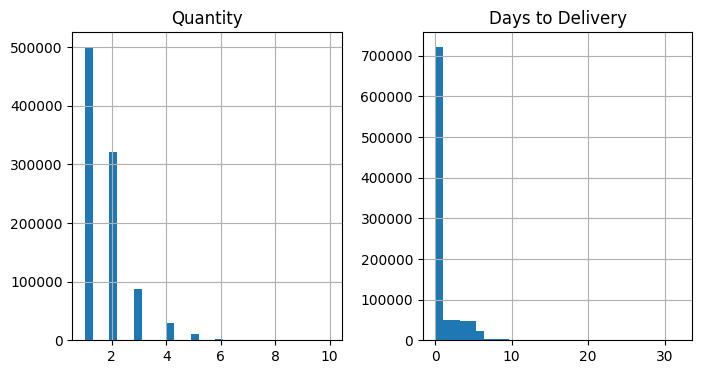

In [ ]:
# Missing & duplicate values
print("Missing values:\n", data.isnull().sum())
print("Duplicate rows:", data.duplicated().sum())

# Descriptive stats
print(data.describe(include="all").T)

# Plot distributions for numeric features
numeric_cols = ['Quantity', 'Total Revenue', 'Unit Cost', 'Profit', 'Days to Delivery']
data[numeric_cols].hist(bins=30, figsize=(8, 4))
plt.show()

#Cleaning Missing Values

In [ ]:
# Fill City & State_Province missing with "Unknown"
data["City"] = data["City"].fillna("Unknown")
data["State_Province"] = data["State_Province"].fillna("Unknown")

# Drop Postal_Code (too granular, many missing)
data = data.drop(columns=["Postal_Code"])

#Handling Duplicates

In [ ]:
# Check if duplicates are full-row identical
duplicates = data[data.duplicated(keep=False)]
display(duplicates)

,Quantity,City,Continent,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
25808,1,Köln,Europe,Nordrhein-Westfalen,08MAR2012,08MAR2012,$59.70,$59.90,.,Retail Sale,Germany,15MAR1958,Orion Club members,Orion Club members medium activity,1230368036,($0.20),0,99,29993
25809,1,Köln,Europe,Nordrhein-Westfalen,08MAR2012,08MAR2012,$59.70,$59.90,.,Retail Sale,Germany,15MAR1958,Orion Club members,Orion Club members medium activity,1230368036,($0.20),0,99,29993
59722,2,Roma,Europe,Lazio,24MAY2012,24MAY2012,$26.40,$11.90,.,Retail Sale,Italy,18SEP1993,Orion Club Gold members,Orion Club Gold members high activity,1230792924,$2.60,0,99,91394
59723,2,Roma,Europe,Lazio,24MAY2012,24MAY2012,$26.40,$11.90,.,Retail Sale,Italy,18SEP1993,Orion Club Gold members,Orion Club Gold members high activity,1230792924,$2.60,0,99,91394
60474,1,Madrid,Europe,"Madrid, Comunidad de",26MAY2012,29MAY2012,$55.10,$55.30,.,Catalog Sale,Spain,08MAR1968,Orion Club Gold members,Orion Club Gold members high activity,1230801908,($0.20),3,0,74401
60475,1,Madrid,Europe,"Madrid, Comunidad de",26MAY2012,29MAY2012,$55.10,$55.30,.,Catalog Sale,Spain,08MAR1968,Orion Club Gold members,Orion Club Gold members high activity,1230801908,($0.20),3,0,74401
71115,2,Brooklyn,North America,New York,17JUN2012,17JUN2012,$53.98,$20.46,.,Retail Sale,United States,17JUL1997,Orion Club members,Orion Club members low activity,1230923543,$13.06,0,99,6901
71116,2,Brooklyn,North America,New York,17JUN2012,17JUN2012,$53.98,$20.46,.,Retail Sale,United States,17JUL1997,Orion Club members,Orion Club members low activity,1230923543,$13.06,0,99,6901
85385,2,Floral Park,North America,New York,17JUL2012,17JUL2012,$85.60,$43.00,.,Retail Sale,United States,09AUG1958,Orion Club members,Orion Club members low activity,1231089144,($0.40),0,99,21840
85386,2,Floral Park,North America,New York,17JUL2012,17JUL2012,$85.60,$43.00,.,Retail Sale,United States,09AUG1958,Orion Club members,Orion Club members low activity,1231089144,($0.40),0,99,21840


In [ ]:
data = data.drop_duplicates()

**Handling Missing Values and Duplications**
City (135 missing) - very small fraction of total rows. Fill with "Unknown" → keeps consistency when aggregating by customer.
Small proportion but still meaningful.

Postal code is very granular and often not useful for clustering (too many categories).Drop column (since we’re already using Continent / Country / State for geography, and Postal Code rarely adds marketing value).

State Province (117,192 missing → 12%)
This is large. Dropping all rows would lose too much data.Fill with "Unknown".

In the Duplicates dataframe, all the records are true duplicate (exact same order ID, customer ID  recorded twice → hence it is removed).


#Aggregate to 1 row per customer


In [ ]:
# Clean and convert currency columns to numeric
for col in ['Total Revenue', 'Unit Cost', 'Profit']:
    data[col] = data[col].astype(str).str.replace('[$,()]', '', regex=True)
    data[col] = pd.to_numeric(data[col])

# Convert date columns to datetime objects
data["Order_Date"] = pd.to_datetime(data["Order_Date"])
data["Delivery_Date"] = pd.to_datetime(data["Delivery_Date"])
data["Customer_BirthDate"] = pd.to_datetime(data["Customer_BirthDate"])

# Aggregate data to 1 row per customer
customer_df = data.groupby("Customer ID").agg({
    "Order_Date": ["min","max","count"],
    "Total Revenue": "sum",
    "Unit Cost": "mean",
    "Customer_BirthDate": "min"
}).reset_index()

customer_df.columns = ["Customer_ID", "first_order", "last_order", "frequency",
                       "CLV", "avg_unit_cost", "birthdate"]

# Recency = days since last order
max_date = customer_df["last_order"].max()
customer_df["recency"] = (max_date - customer_df["last_order"]).dt.days

# Customer age
customer_df["customer_age"] = (max_date.year - customer_df["birthdate"].dt.year)

# Keep only required features
features = ["frequency", "recency", "CLV", "avg_unit_cost", "customer_age"]
X = customer_df[features]

display(customer_df.head())


/tmp/ipython-input-4058570768.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Order_Date"] = pd.to_datetime(data["Order_Date"])
/tmp/ipython-input-4058570768.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Delivery_Date"] = pd.to_datetime(data["Delivery_Date"])
/tmp/ipython-input-4058570768.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Customer_BirthDate"] = pd.to_datetime(data["Customer_BirthDate"])


,Customer_ID,first_order,last_order,frequency,CLV,avg_unit_cost,birthdate,recency,customer_age
0,1,2013-09-07,2016-12-13,35,4322.70,89.622857,1953-11-24,17,63
1,3,2012-02-19,2016-08-28,20,2821.00,90.505000,1983-07-01,124,33
2,4,2013-03-02,2013-12-18,9,782.67,37.195556,1983-06-27,1108,33
3,5,2012-01-15,2016-12-25,19,2810.98,107.947368,1988-07-08,5,28
4,6,2013-02-17,2016-06-21,15,1604.58,52.526667,1958-12-23,192,58


#Outlier Detection

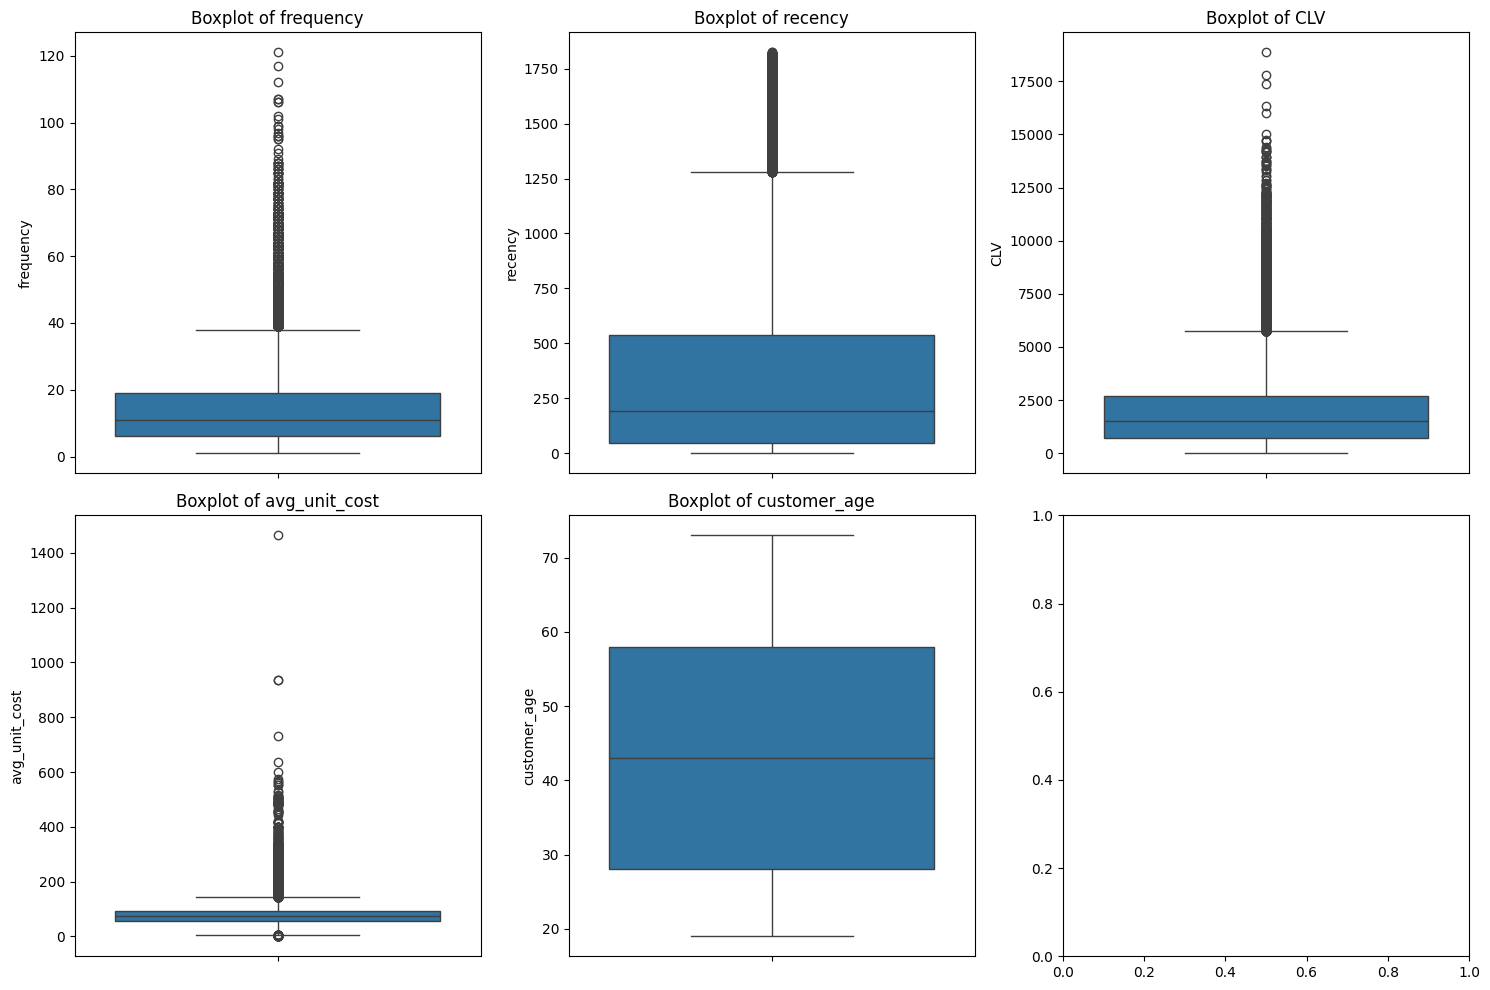

In [ ]:
# Use Boxplots for quick visual check

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(X):
    sns.boxplot(y=customer_df[col], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [ ]:
#IQR (Interquartile Range) Method
def detect_outliers_iqr(X, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return X[(X[column] < lower) | (X[column] > upper)]

# Check for each feature
for col in X:
    outliers = detect_outliers_iqr(customer_df, col)
    print(f"{col}: {len(outliers)} outliers")


frequency: 2654 outliers
recency: 3361 outliers
CLV: 2590 outliers
avg_unit_cost: 2889 outliers
customer_age: 0 outliers


For the detected outliers:
The 2654 frequency outliers indicates a small but important segment of very frequent buyers.
The 3361 recency outliers indicates a segment of customers who haven't made a purchase in a very long time (up to 1800 days or about 5 years). The lower whisker is very close to zero, suggesting many recent purchasers.
The boxplot and IQR method shows the CLV variable have a vast number of significant outliers that extend up to $18,000 or more. This indicates that most of the company's lifetime value comes from a very small group of high-value customers.
There are numerous average unit cost outliers extending up around $1400. These likely represent customers who occasionally or regularly purchase very expensive items.
The outlier detection has 0 customer age outlier - suggesting that the customer base has a reasonably standard age distribution, ranging from about 20 to 70 years old.

The detected outliers in frequency, CLV, average unit cost represents real VIP, we should keep them. There were no customer age outlier. For the recency outliers, we will keep them because long inactivity is meaningful to study their profile and clustering for future strategy formation.



#EDA for Engineered Features

                 count         mean          std    min         25%      50%  \
frequency      68300.0    13.933353    11.328807   1.00    6.000000    11.00   
recency        68300.0   367.662167   414.511202   0.00   45.000000   190.00   
CLV            68300.0  1950.148420  1719.916365   0.63  696.000000  1497.40   
avg_unit_cost  68300.0    78.895675    38.005259   0.50   57.579792    73.45   
customer_age   68300.0    43.103324    17.472397  19.00   28.000000    43.00   

                      75%       max  
frequency        19.00000    121.00  
recency         539.25000   1824.00  
CLV            2709.84500  18860.96  
avg_unit_cost    92.51526   1463.50  
customer_age     58.00000     73.00  


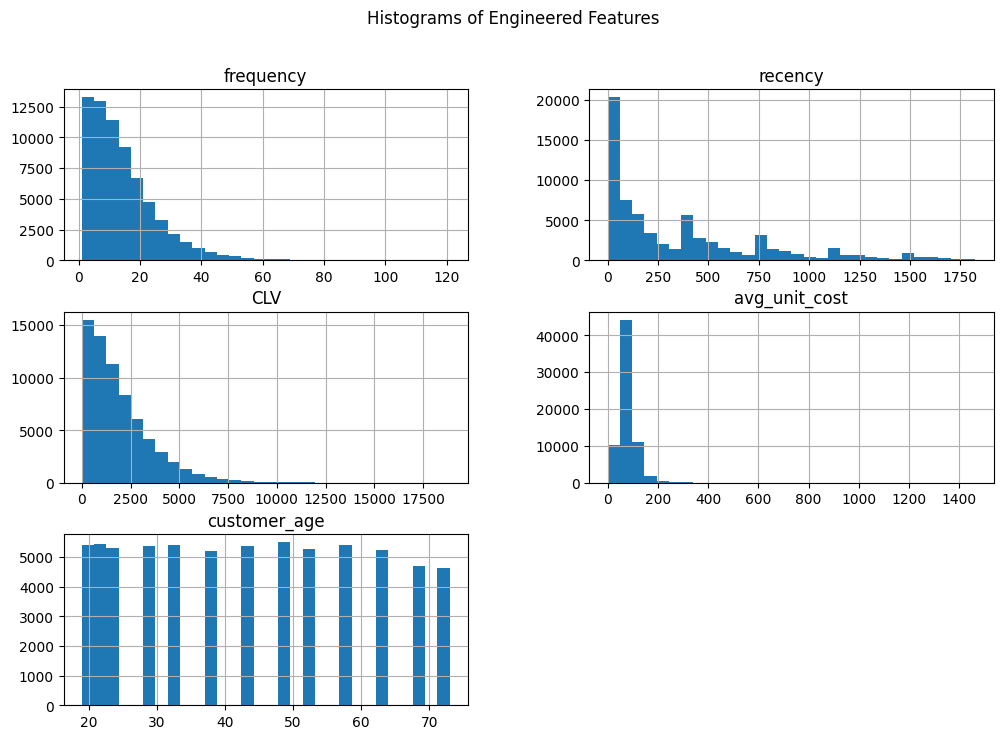

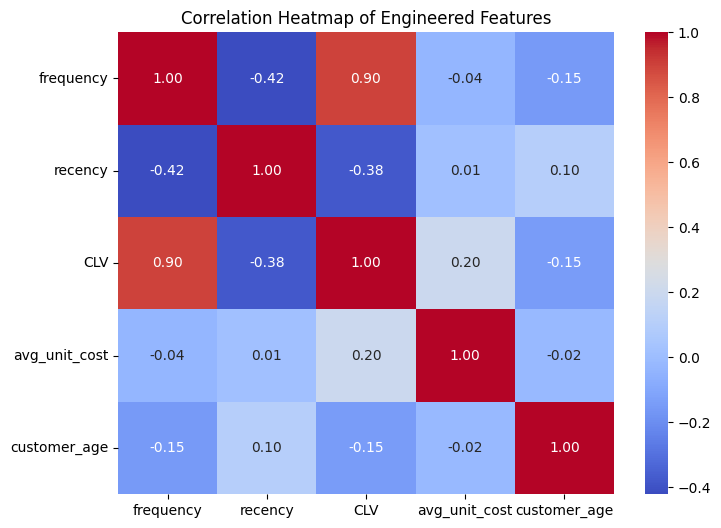

In [ ]:
# Descriptive statistics
print(X.describe().T)

# Histograms
X.hist(bins=30, figsize=(12,8))
plt.suptitle("Histograms of Engineered Features")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


**Interpretation**
Descriptive Statistics

Frequency- The mean (13.9) is higher than the median (11.0), confirming the right-skew observed in the boxplot and histogram. Most customers have a low purchase count, with a max of 121.

Recency -	The mean (367.7 days) is much higher than the median (190.0 days), indicating a strong right-skew. 50% of customers made a purchase within 190 days, but the average is driven up by customers with a high recency (max of 1824 days, or about 5 years).

CLV	- The mean ($1,950) is significantly higher than the median ($1,497.40), which confirms the right-skew and the existence of high-value customers driving up the average. The range is enormous, from $0.63 to $18,860.96.

avg_unit_cost	The mean ($78.96) is slightly higher than the median ($73.45). The standard deviation ($38) is relatively small compared to the range, suggesting most customers buy items in a narrow price band, but a maximum of $1463.50 confirms the high-cost outliers.

customer_age	The mean (43.1 years) and median (43.0 years) are nearly identical, indicating an almost perfect symmetrical distribution. The customer base ranges from 19 to 73 years old.

Histogram

The histograms visually confirm the distribution shapes implied by the descriptive statistics.

Frequency, Recency, and CLV: All show a severe right-skew, with most data points clustered close to zero and a long tail extending to the right. This reaffirms that a majority of customers have low values for these metrics, while a small group holds the extreme high values.

avg_unit_cost: This is also heavily right-skewed and peaked, this shows most transactions are for very cheap items.

customer_age: This histogram shows a distribution that is close to uniform (or rectangular), with similar counts across all age bins from 20 to 70. This is consistent with the similar mean and median, and indicates that the customer base is evenly spread across adult ages.

Correlation Heatmap

Strongest Correlations (Most Important)
CLV and Frequency (+0.90): This is a very strong positive correlation. The more frequently a customer purchases, the higher their Customer Lifetime Value is. This is the most significant driver of CLV.

Recency and Frequency (−0.42): This is a moderate negative correlation. The more recently a customer has purchased (lower Recency value), the higher their total purchase Frequency is. This is expected: active customers purchase more often overall.

CLV and Recency (−0.38): This is a moderate negative correlation. Customers who have purchased more recently (low Recency) tend to have a higher overall CLV.

Weak/Negligible Correlations (Least Important)

avg_unit_cost and everything else: The correlations are all very low (e.g., +0.20 with CLV, −0.04 with Frequency). This suggests that the average price a customer pays for an item does not strongly influence their CLV or purchase behavior. This is a key insight: volume (Frequency) is more important than price (avg_unit_cost) for driving CLV.

customer_age and everything else: All correlations are very close to zero (max +0.10 with Recency). Customer age is not a strong predictor of purchase frequency, recency, CLV, or average unit cost in this dataset.



#Feature Scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#Finding the optimum value of clusters ( k ) - Elbow Method

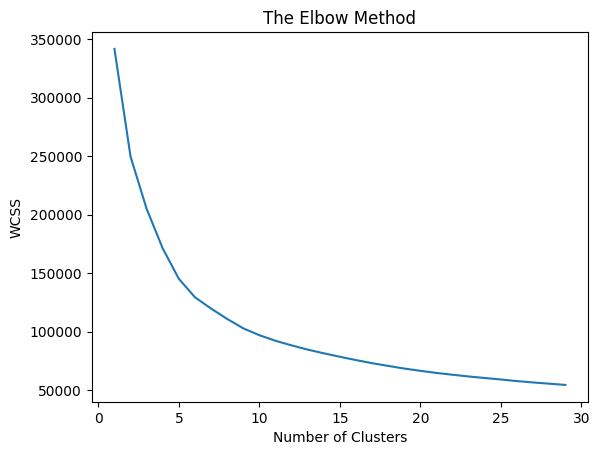

In [ ]:
# Elbow method: try different k.
wcss=[]
for i in range(1,30):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0, n_init = 30)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,30),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**Interpreting the Elbow**
Initial Sharp Drop: There's a very sharp decrease in WCSS from k=1 to k=3. This indicates that adding these initial clusters significantly improves the model's ability to group similar data points.

The Elbow Point: The most noticeable bend, or "elbow," where the curve starts to level off occurs around k=4 and k=5.

The improvement from k=4 to k=5 is still noticeable.

The improvement from k=5 to k=6 is less pronounced.

The Tail: After k=5, the curve becomes much flatter, showing that the marginal benefit (reduction in WCSS) of adding more clusters is minimal and quickly diminishing.

A strong argument can be made for **k=4** as the point where the substantial gains end.

A safe, slightly more detailed choice might be **k=5**.

The plot itself goes up to k=29. While the optimal k is small, the method required testing a larger range to confidently identify the elbow. Initially the parameter is set to k=10 to k=20 range showed a nearly flat line, which obscures the initial sharp drop and the true elbow.

In [ ]:
#Let's use k=5 as a safe, detailed choice with Elbow test's interpretation
# Using our best "k" and plotting the results.
clusterer = KMeans(n_clusters = 5,
                   random_state=30,
                   n_init = 30)

clusterlabels = clusterer.fit_predict(X_scaled)
print(clusterlabels)

[3 1 0 ... 3 2 0]


#Finding the optimum value of clusters ( k ) - Silhouette method

For n_clusters = 3 The average silhouette_score is : 0.25281080840185716
For n_clusters = 4 The average silhouette_score is : 0.25319212425565557
For n_clusters = 5 The average silhouette_score is : 0.2671414291898342
For n_clusters = 6 The average silhouette_score is : 0.2527654741398695
For n_clusters = 7 The average silhouette_score is : 0.23487370935195567


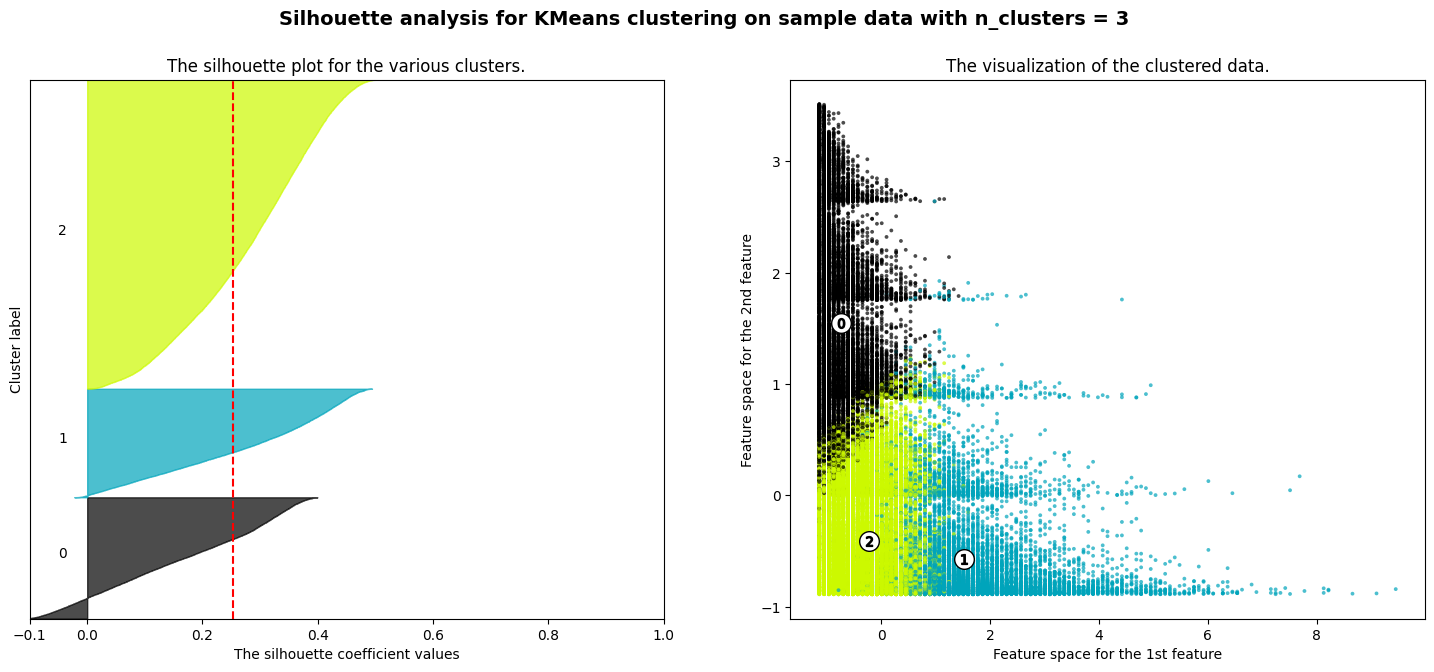

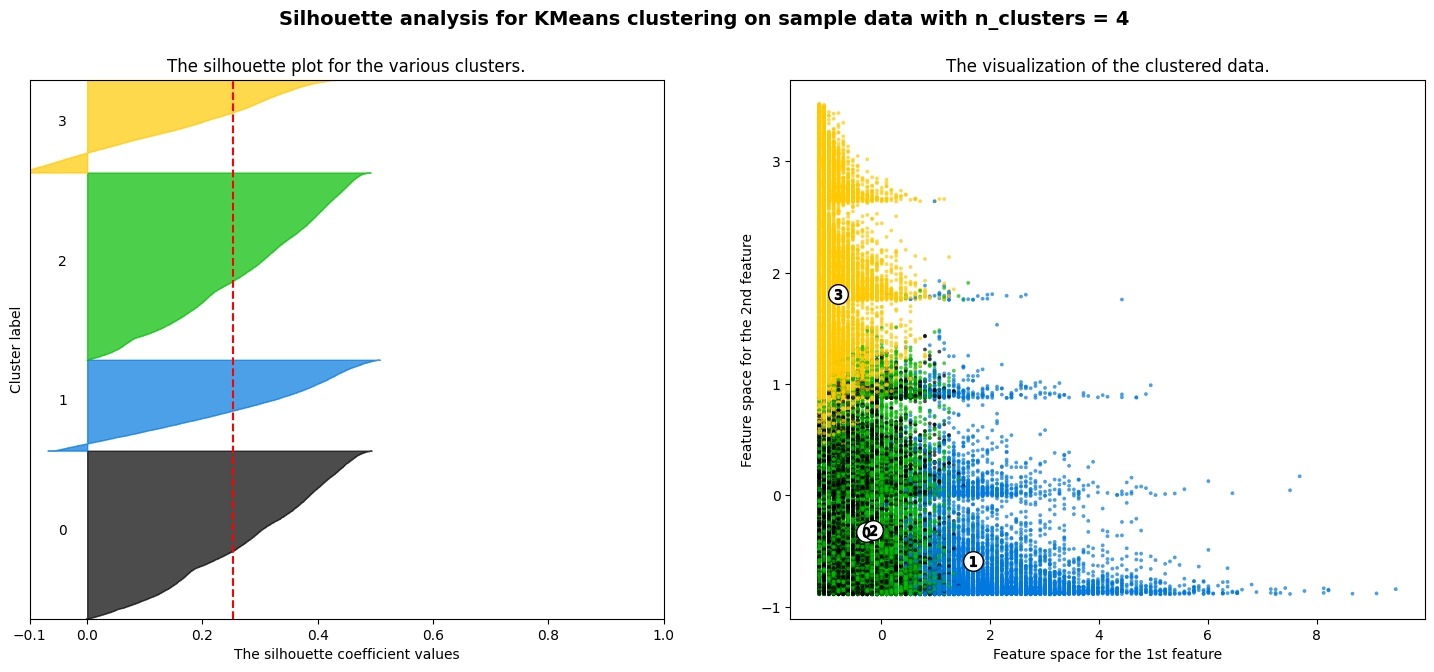

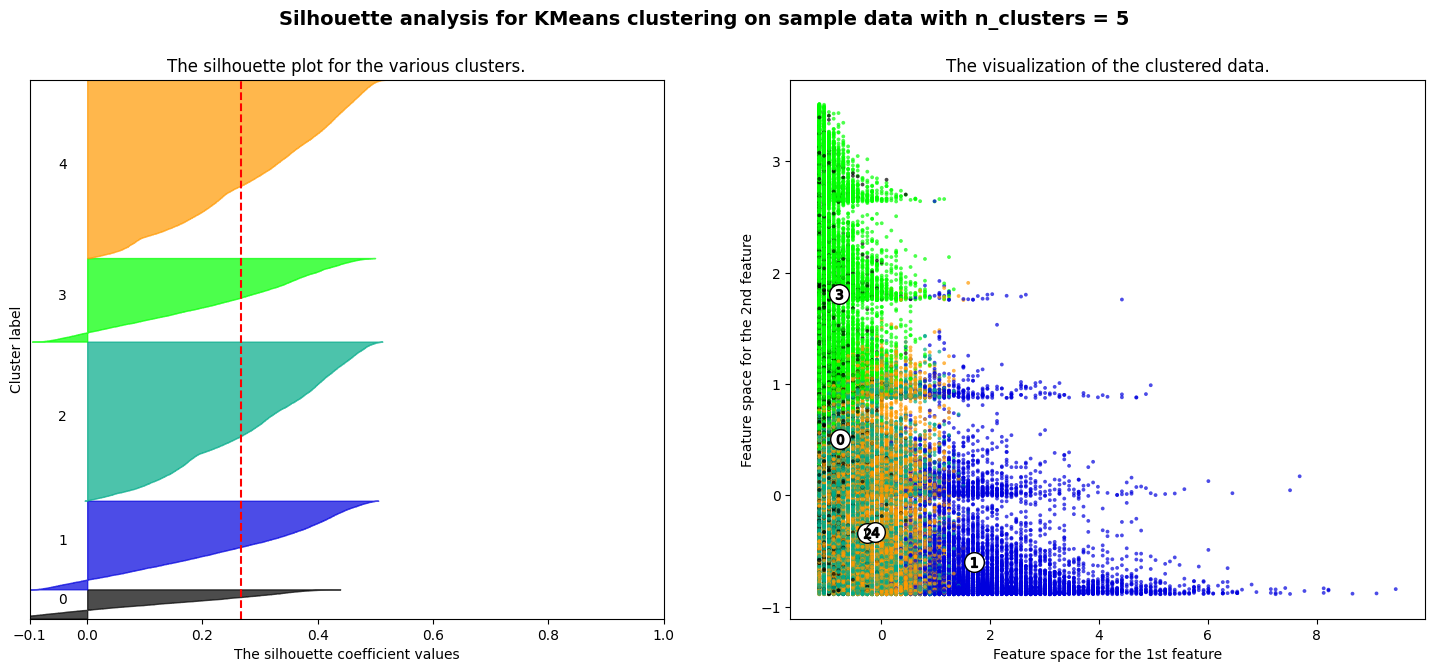

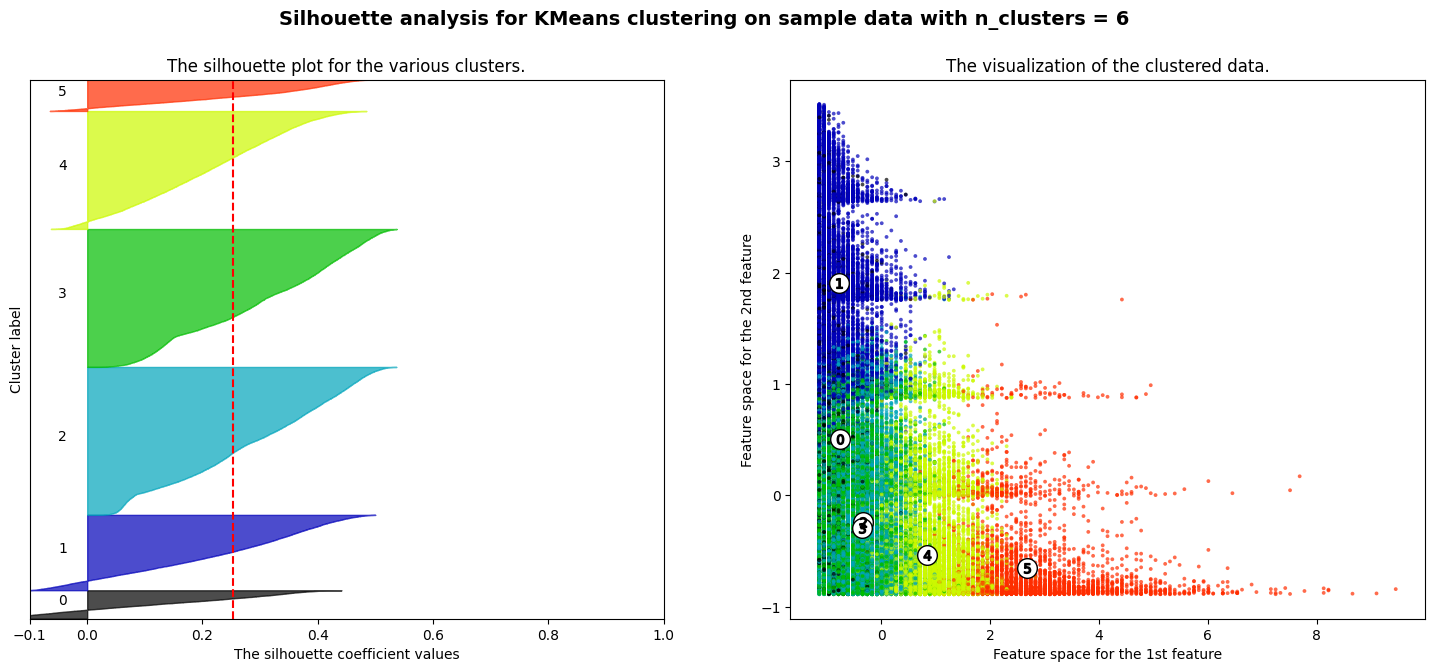

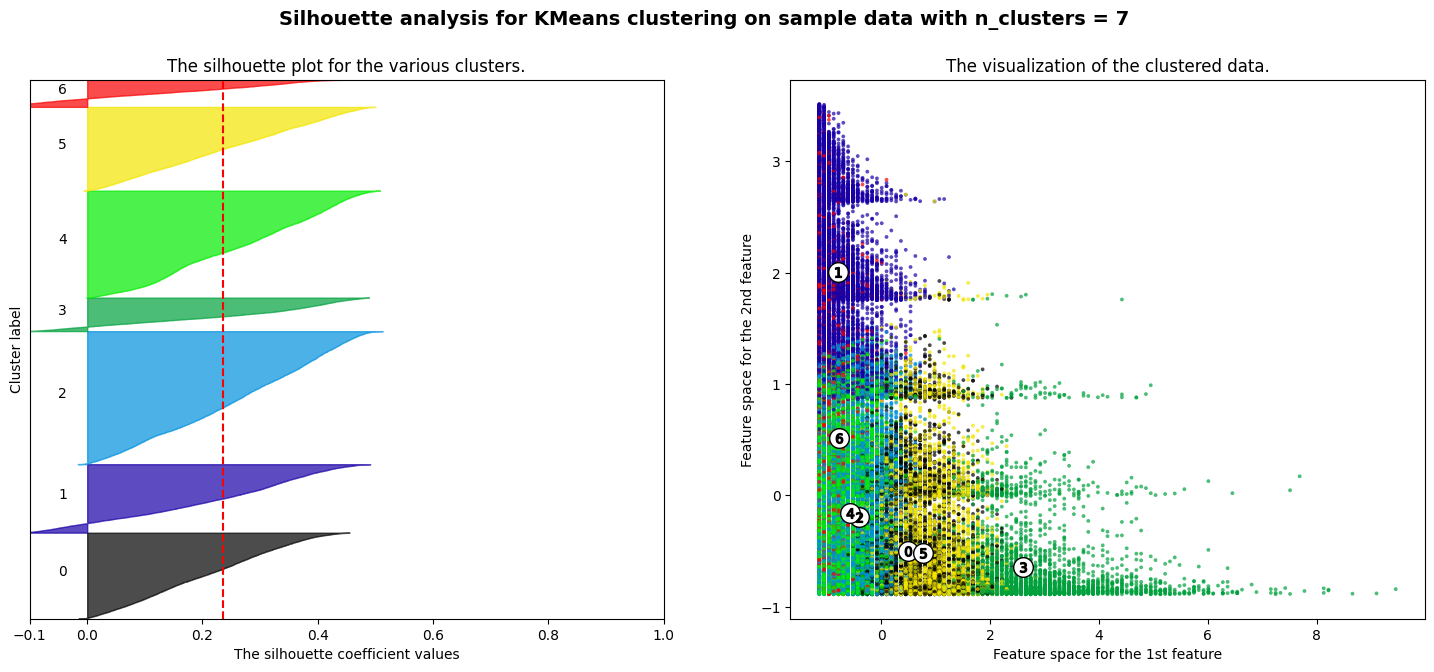

In [ ]:
import matplotlib.cm as cm

for n_clusters in [3,4,5,6,7]:
    # Create a subplot with 1 row and 2 columns.
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot.
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1].
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 10)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot.
        y_lower = y_upper + 10  # 10 for the 0 samples.

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks.
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters.
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers.
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Based purely on these scores, the optimal number of clusters is:

k=5

It has the highest average Silhouette Score (0.2671), meaning that the data points are, on average, best matched to their own cluster and furthest from their neighboring clusters at this level of segmentation.

A score in the 0.23 to 0.27 range is generally considered low.
The low scores suggest that the customer segments are not naturally forming into tight, distinct, and well-separated groups.

#Hierarchical Clustering

Subsampling complete. New DataFrame size: 30000
NumPy array shape for linkage: (30000, 5)
Computing linkage matrix using 'ward' method...
Linkage matrix computed successfully.


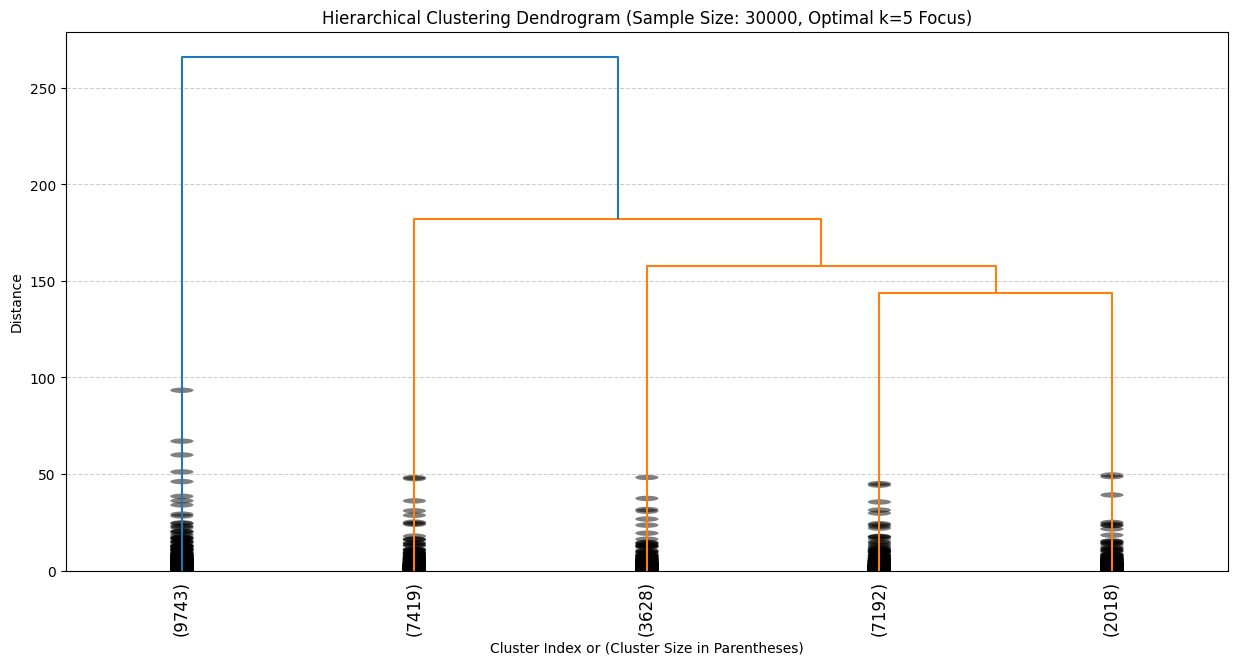


Visualization complete.


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd # Import pandas

#Subsample the Data (Crash Prevention Step)
# Convert X_scaled back to a DataFrame to use .sample()
X_scaled_df = pd.DataFrame(X_scaled, columns=["frequency", "recency", "CLV", "avg_unit_cost", "customer_age"])
small_df = X_scaled_df.sample(n=30000, random_state=42).reset_index(drop=True)
print(f"Subsampling complete. New DataFrame size: {len(small_df)}")

#Extract Features into a NumPy Array for linkage
X_sample = small_df.values
print(f"NumPy array shape for linkage: {X_sample.shape}")


LINKAGE_METHOD = 'ward'
P_TRUNCATE = 5

#Compute the Linkage Matrix
print(f"Computing linkage matrix using '{LINKAGE_METHOD}' method...")
linked_matrix = linkage(X_sample, method=LINKAGE_METHOD)
print("Linkage matrix computed successfully.")

#Plot the Truncated Dendrogram
plt.figure(figsize=(15, 7))
dendrogram(
    linked_matrix,
    truncate_mode='lastp',
    p=P_TRUNCATE,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)

plt.title(f'Hierarchical Clustering Dendrogram (Sample Size: {len(small_df)}, Optimal k={P_TRUNCATE} Focus)')
plt.xlabel('Cluster Index or (Cluster Size in Parentheses)')
plt.ylabel('Distance')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\nVisualization complete.")

The dendrogram was generated using a sample size of 30,000 customers, which represents approximately 44% of the total dataset.

The subsampling was a necessary computational strategy employed because the standard hierarchical clustering algorithm (linkage) has an O(n
2
 ) memory complexity. Running this operation on the full 68,300 customer dataset requires an estimated 37 GB of RAM, which exceeds the resource limits of the Google Colab environment and would result in a kernel crash. By reducing the sample size to 30,000, the memory requirement was reduced to an estimated 7.2 GB, allowing the visualization to be generated successfully while still providing a robust view of the data's underlying hierarchical structure.


The dendrogram visually confirms the hierarchical structure of the data and provides a visual validation for K-Means result of k=5.

To get 5 clusters, find a height (Distance on the Y-axis) that is crossed by exactly five vertical lines.

The two highest clusters merge at a distance of about 270. This is the highest level of dissimilarity.

The current structure clearly shows 4 main groups merging at a distance of approximately 180.

Look slightly lower to achieve 5 distinct clusters. The four main branches split into 5 distinct vertical segments just below the 150-160 distance mark.

The dendrogram is truncated to show only the last few merges, with the size of the cluster represented by the number in parentheses at the bottom.


Cluster 1 (9743): A very large, distinct group that merges with the rest of the data at a high distance (∼270). This often represents the largest segment, likely the Low-Frequency/High-Recency/Low-CLV group (Dormant or New customers).

Cluster 2 (7419): The second-largest group, merging at a distance of around ∼180.

Cluster 3 (3628)

Cluster 4 (7192)

Cluster 5 (2018)

The remaining four groups (7419, 3628, 7192, 2018) merge amongst themselves at lower distances (below 180), suggesting they are more similar to each other than to the largest cluster (9743). These likely represent the different stages of the Active/Loyal/High-CLV customer base.

The dendrogram visually supports the K-Means finding of k=5. The vertical drops show that five distinct partitions exist, and the heights of the merges (the distances) demonstrate that these five groups are separated by clear, meaningful differences, validating the utility of segmenting the customer base into five groups.

#Perform k-means clustering

Starting K-Means iterative visualization on Scaled Frequency vs Scaled CLV...


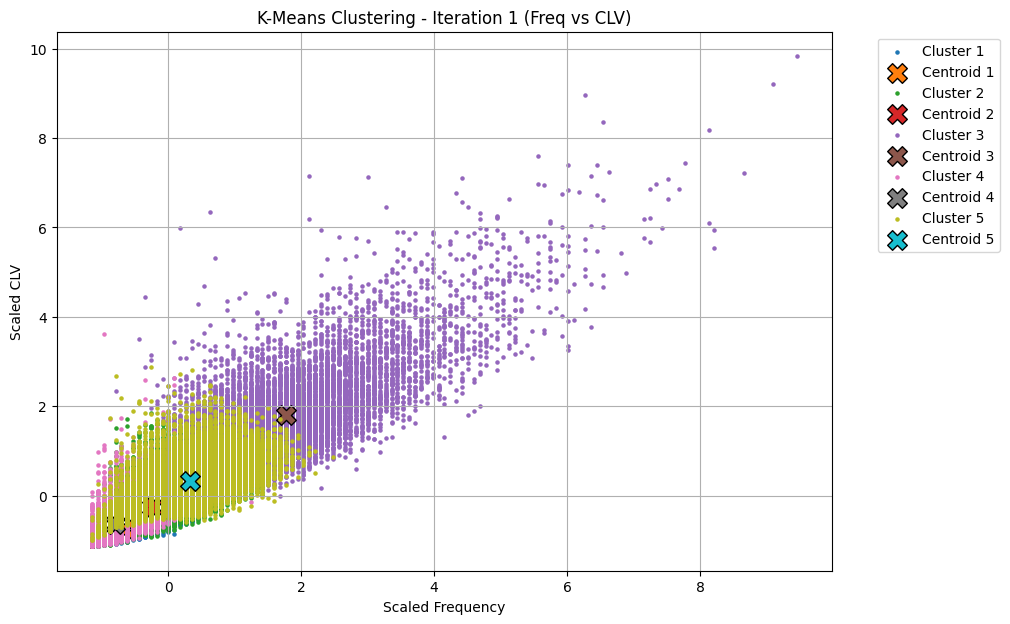

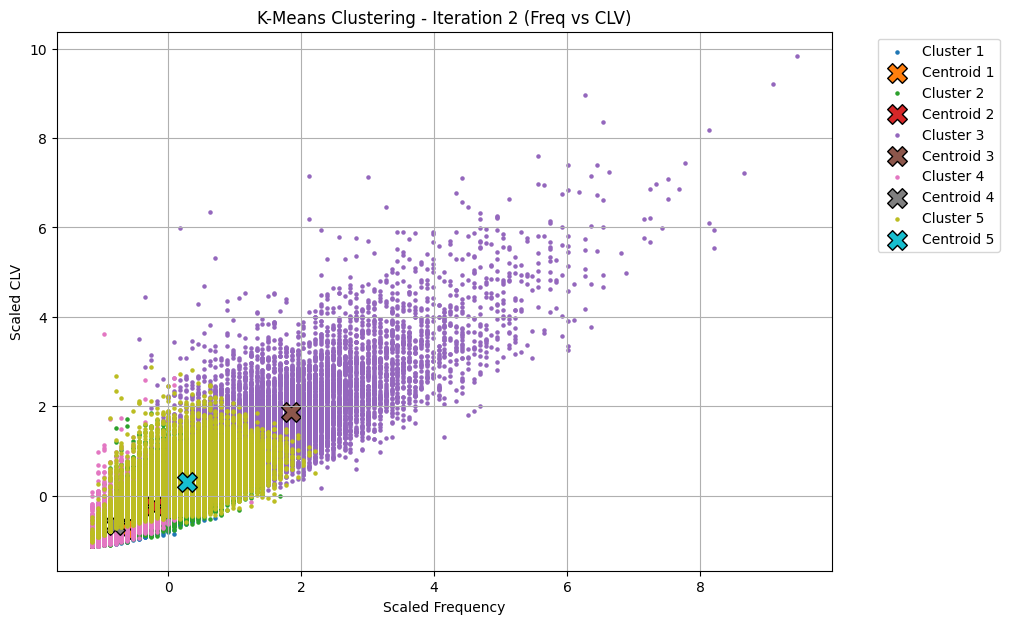

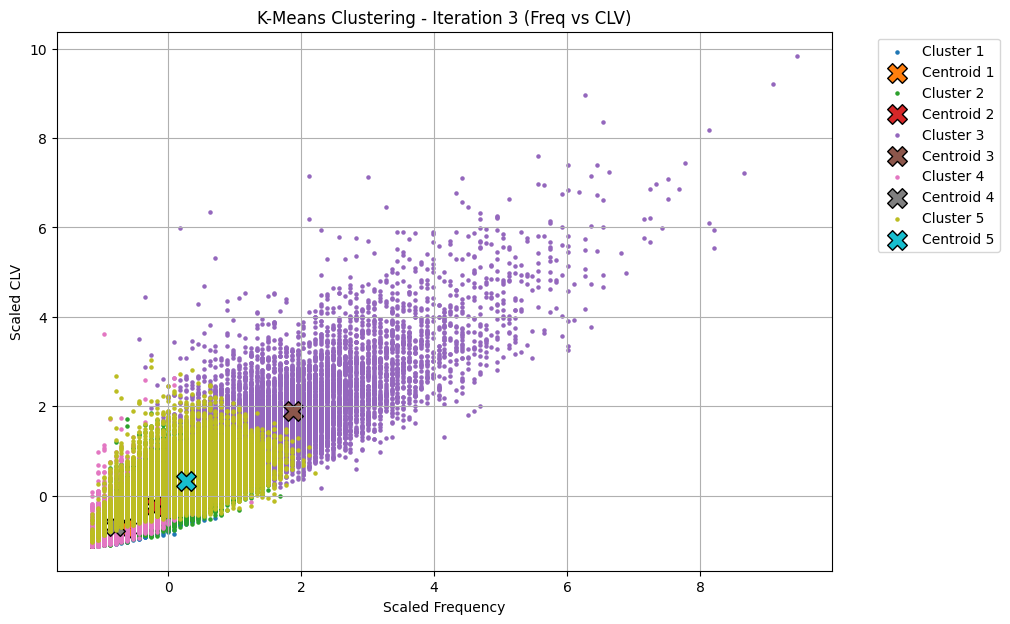

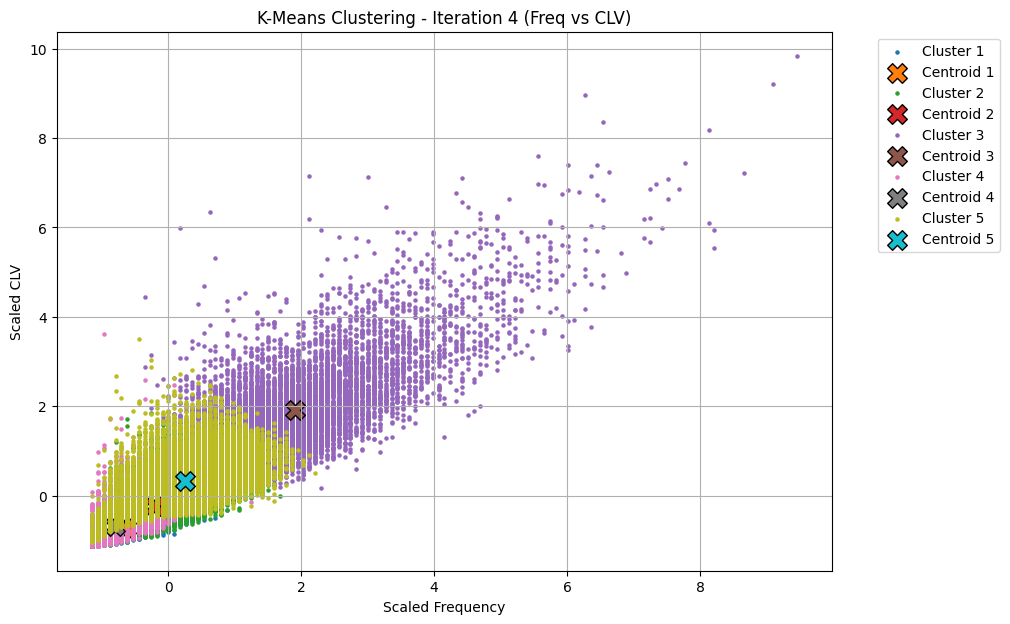

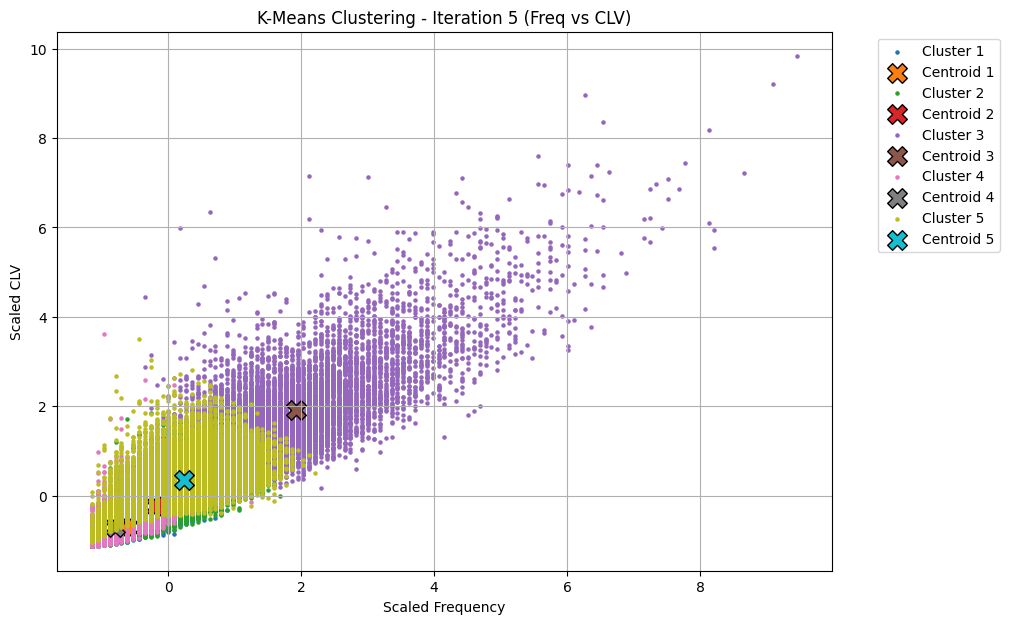


Visualization sequence complete.


In [ ]:
OPTIMAL_K = 5
MAX_VISUAL_ITERATIONS = 5
RANDOM_STATE = 42
FEATURE_X_INDEX = 0  # Index for Scaled Frequency
FEATURE_Y_INDEX = 2  # Index for Scaled CLV
# Assuming X_scaled contains the 5 scaled features in order: F, R, CLV, Cost, Age

#Initialization
kmeans_model = KMeans(n_clusters=OPTIMAL_K, n_init=1, max_iter=1, random_state=RANDOM_STATE)
kmeans_model.fit(X_scaled)
current_centroids = kmeans_model.cluster_centers_

print("Starting K-Means iterative visualization on Scaled Frequency vs Scaled CLV...")

# Iterative Plotting Loop
for i in range(MAX_VISUAL_ITERATIONS):

    # 1. Update the model to use the last iteration's centroids as the starting points
    kmeans_model = KMeans(
        n_clusters=OPTIMAL_K,
        init=current_centroids,
        n_init=1,
        max_iter=1,
        random_state=RANDOM_STATE
    )

    # 2. Fit the model and get the new labels
    kmeans_model.fit(X_scaled)
    current_labels = kmeans_model.labels_
    current_centroids = kmeans_model.cluster_centers_

    # --- 3. Plotting for the Current Iteration ---
    plt.figure(figsize=(10, 7))
    plt.title(f'K-Means Clustering - Iteration {i + 1} (Freq vs CLV)')

    for cluster_idx in range(OPTIMAL_K):
        # Filter data for the current cluster
        cluster_data = X_scaled[current_labels == cluster_idx]

        # Scatter plot the data points
        plt.scatter(cluster_data[:, FEATURE_X_INDEX],
                    cluster_data[:, FEATURE_Y_INDEX],
                    s=5,
                    label=f'Cluster {cluster_idx + 1}')

        # Plot the centroid (X)
        plt.scatter(current_centroids[cluster_idx, FEATURE_X_INDEX],
                    current_centroids[cluster_idx, FEATURE_Y_INDEX],
                    s=200,
                    marker='X',
                    edgecolor='black',
                    label=f'Centroid {cluster_idx + 1}')

    plt.xlabel('Scaled Frequency')
    plt.ylabel('Scaled CLV')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

print("\nVisualization sequence complete.")

The visual interpretation is limited by its 2-dimensional projection.

The Overlapping Low-Value Clusters: K-Means is forced to carve three separate segments (Clusters 1, 2, 4, and 5) out of this single, dense cloud, in addition to capturing the high-value outliers (Cluster 3).

Clusters 2 and 4 (Dark Green and Pink) are physically overlapping at the absolute lowest point of value. Their separation is likely happening in the other three dimensions (Recency, Avg Unit Cost, Customer Age), where the distance calculation is finding meaningful but subtle differences that are invisible when projected onto just two axes.

The vast majority of data points are clustered in a dense mass near the origin (Scaled Frequency ≈0, Scaled CLV ≈0). This represents the bulk of customers with low engagement and low value.

A long, sparse tail of customers stretches diagonally into the upper-right corner (up to Scaled Frequency ≈9 and Scaled CLV ≈10), representing the small percentage of customers driving the highest value.


Customer count per cluster:
cluster
0    20164
1    10582
2    22581
3    11248
4     3725
Name: count, dtype: int64

Sample of data with cluster labels:


,Customer_ID,frequency,recency,avg_unit_cost,customer_age,cluster
0,1,35,17,89.622857,63,3
1,3,20,124,90.505000,33,2
2,4,9,1108,37.195556,33,1
3,5,19,5,107.947368,28,2
4,6,15,192,52.526667,58,0


/tmp/ipython-input-3265692991.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_count.index, y=cluster_count.values, palette="viridis")


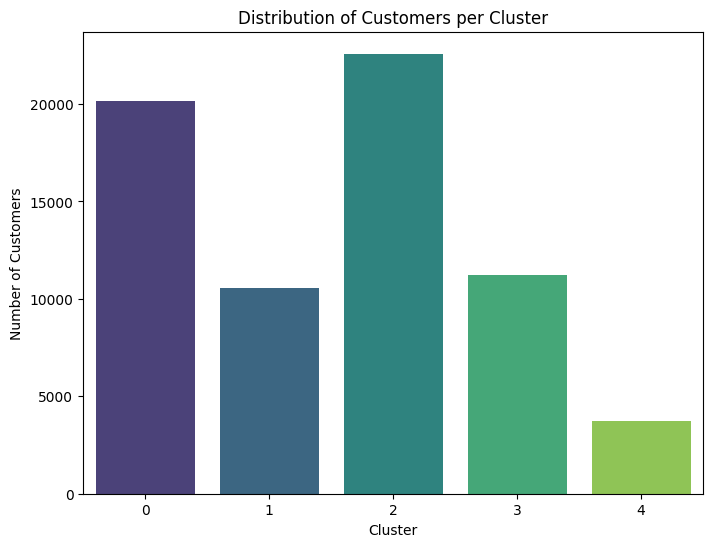

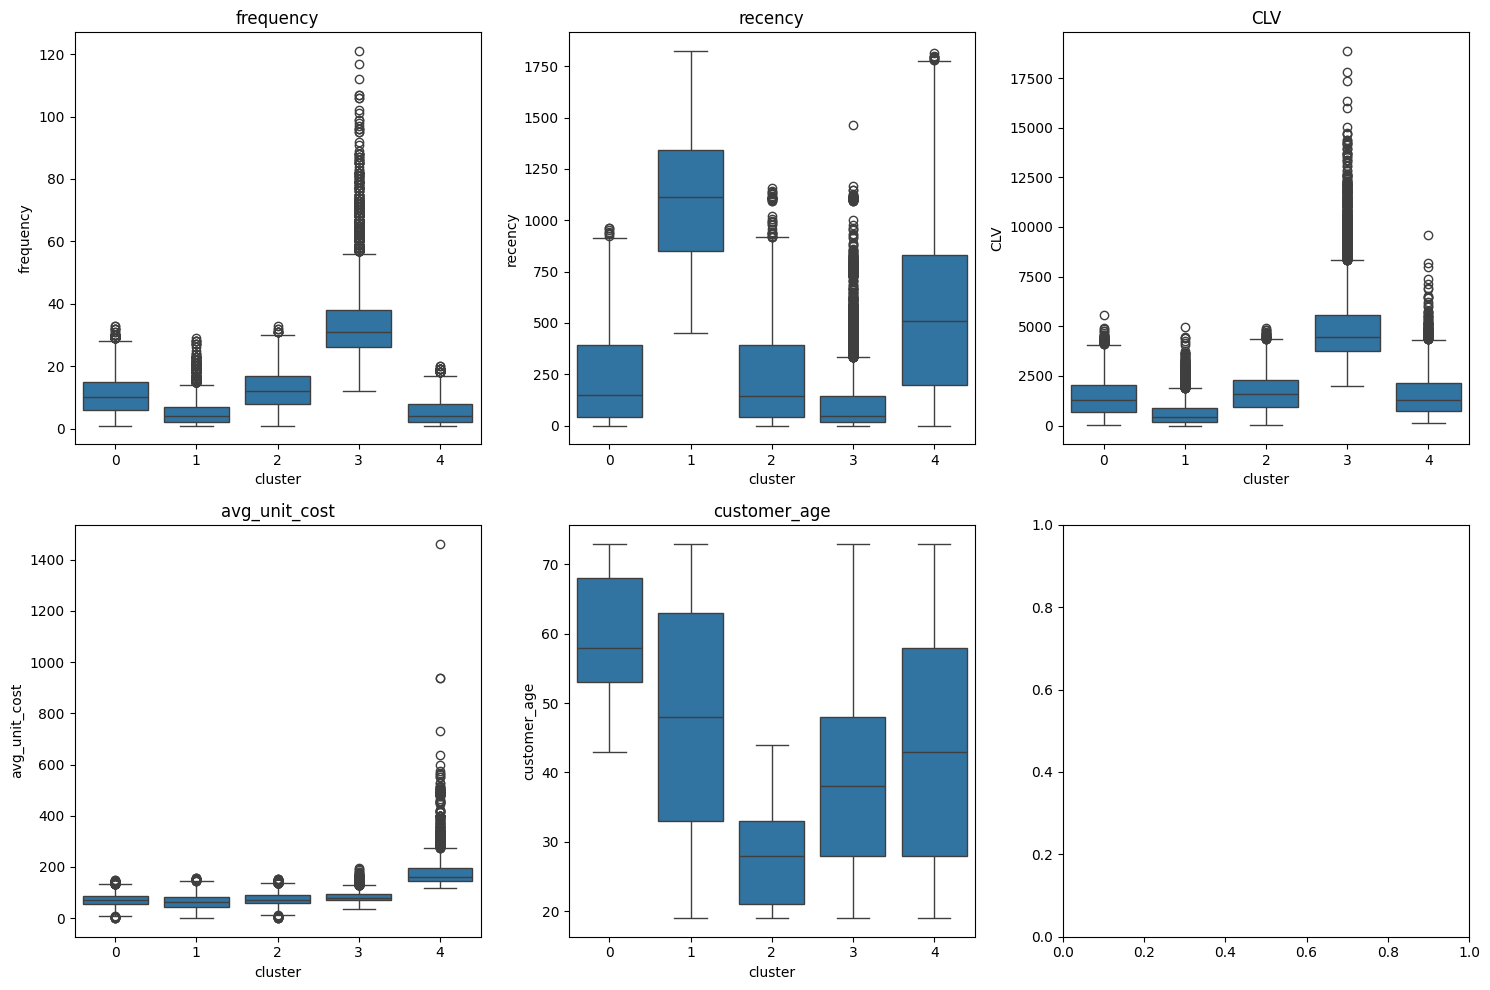

In [ ]:
optimum_k = 5
kmeans = KMeans(n_clusters=optimum_k, random_state=42, n_init=10)
customer_df["cluster"] = kmeans.fit_predict(X_scaled)

# Table of clusters
cluster_table = customer_df[["Customer_ID","frequency", "recency","avg_unit_cost","customer_age","cluster"]]
print("Customer count per cluster:")
print(cluster_table["cluster"].value_counts().sort_index())

print("\nSample of data with cluster labels:")
display(cluster_table.head())

# Bar plot of cluster counts
plt.figure(figsize=(8, 6))
cluster_count = customer_df["cluster"].value_counts().sort_index()
sns.barplot(x=cluster_count.index, y=cluster_count.values, palette="viridis")
plt.title("Distribution of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


# Boxplots by cluster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features_to_plot = ["frequency", "recency", "CLV", "avg_unit_cost", "customer_age"]
for i, col in enumerate(features_to_plot):
    sns.boxplot(x="cluster", y=col, data=customer_df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

**Boxplot Interpretation of k=5 Customer Clusters**

The outliers, while numerous, are essential here because the clustering algorithm is designed to group data points based on their distance in a multi-dimensional space. The boxplots show that k=5 has successfully segregated customers based on these differences.

**1. High-Value/Low-Value Separation (Frequency & CLV)**
The boxplots for Frequency and CLV show a clear division of customer value:

Cluster 3: The Champions/High-Value Segment.

Frequency: Has the highest median frequency (∼18−20) and the largest range, extending up to ∼40 before outliers.

CLV: Shows the highest median CLV (∼5,000) and the highest IQR (interquartile range), clearly marking this as the most valuable, most frequent, and highest-spending segment. This group contains the extreme outliers that drive maximum revenue.

Clusters 0, 1, 2, 4: The Core and Low-Value Segments.

These four clusters all have low medians for both Frequency (all below ∼20) and CLV (all below ∼2,500). This confirms that Cluster 3 is the small, highly profitable Pareto segment, while the others form the base of the customer pyramid.

**2. Recency and Dormancy**
The Recency boxplot is key for identifying customer freshness and risk of churn:

Cluster 1: The At-Risk/Dormant Segment.

This cluster has the highest median recency (∼1,100 days or ∼3 years) and the largest spread. High recency means the customers haven't purchased in a long time.

Profile: These are clearly dormant or lapsed customers.

Clusters 0, 2, 3: The Active/Recent Segments.

These 3 clusters all have significantly lower median recencies (below ∼250 days), indicating they are currently active or recently made purchase.

**3. Average Unit Cost and Purchase Behavior**
The Avg Unit Cost boxplot segments based on the typical price point of items purchased:

Cluster 4: High-Value Shoppers

This cluster has the highest median Avg Unit Cost (∼175), significantly higher than the others (which are all around ∼80).

Profile: These customers prioritize higher-priced items but have low overall frequency/CLV (from Section 1). This is a distinct group to target with premium, low-volume products.

**4. Customer Age and Demographics**
The Customer Age boxplot shows that age is relatively well-distributed across all clusters, except for Cluster 1.

Cluster 2: The Youngest Segment.

This cluster has a significantly lower median age (∼25) and is much tighter than the others.

Profile: This cluster likely represents New or Younger Customers with a generally low value profile.

#Dimensionality Reduction

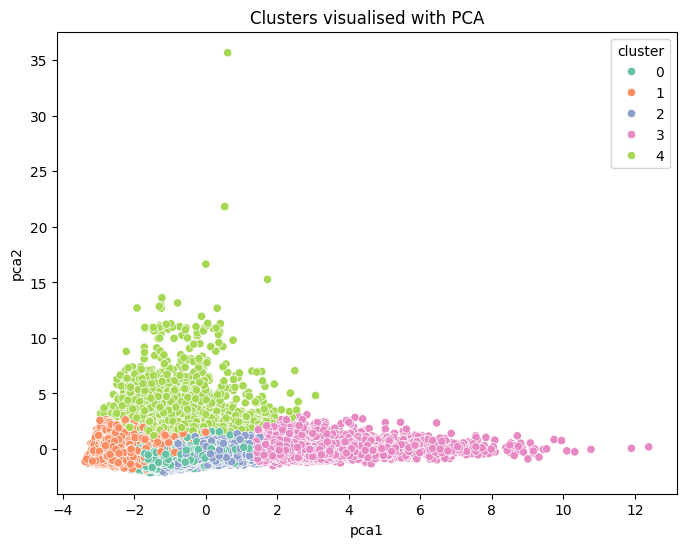

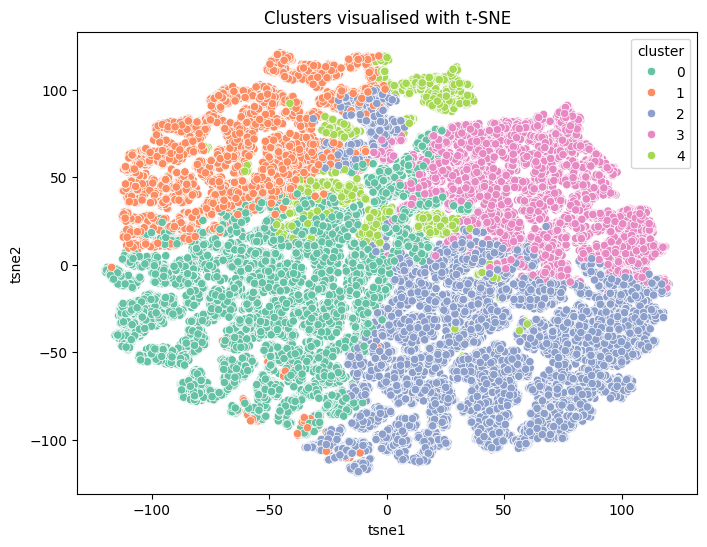

In [ ]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
customer_df["pca1"], customer_df["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x="pca1", y="pca2", hue="cluster", palette="Set2")
plt.title("Clusters visualised with PCA")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled)
customer_df["tsne1"], customer_df["tsne2"] = tsne_result[:,0], tsne_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x="tsne1", y="tsne2", hue="cluster", palette="Set2")
plt.title("Clusters visualised with t-SNE")
plt.show()

The t-SNE visualization is exceptionally good and is far superior to the 2D K-Means projection (Frequency vs. CLV).

The purpose of t-SNE is to find the best possible 2D representation of the high-dimensional data, it provides the clearest validation yet for the k=5 clustering solution.

1. PCA Visualization
The PCA plot projects the data onto the two axes that capture the maximum variance (PC1 and PC2).

The Three Tiers: The PCA plot effectively separates the data into three major tiers:

The large outlier tail (PC1 > 0), primarily Cluster 3 (Pink).

The light green cluster 4 (PC2 > 0).

A small, low-variance group (PC1 < 0).

PCA fails to separate Clusters 0 (Teal), 1 (Orange), and 2 (Blue/Grey) which are heavily intermingled near the origin. This confirms that the differences between these low-value segments are not based on global variance but on localized, subtle patterns.

2. t-SNE Visualization
The t-SNE plot is an iterative, non-linear method designed specifically to capture and resolve the local neighborhood relationships that PCA misses.

The t-SNE successfully pulls the formerly overlapped clusters apart, showing five distinct, well-defined groups.

The Clusters 0, 1, and 4 that were all a blur in the PCA are now cleanly resolved into separate domains.

The success of the t-SNE visualization provides unequivocal visual validation that the K-Means algorithm, operating in 5-dimensional space, did indeed find five statistically robust partitions, even though the differences between some segments (like those near the origin) were subtle.

The combined observation demonstrates that the optimal clustering solution of k=5 is robust. While the PCA confirmed the general value hierarchy, the t-SNE provided the necessary high-fidelity evidence that the subtle differences based on Recency, Age, and Avg Unit Cost were significant enough to warrant five distinct customer segments.